In [ ]:
from google.colab import drive  
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Set the system path for saving and loading libraries
import sys
sys.path.append('/content/drive/MyDrive/library')

In [ ]:
# Check tensorflow and keras versions
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
#Make sure the GPU is available. 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
#import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
#from keras import backend, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN

In [ ]:
sys.path.append('/content/drive/MyDrive/library/keras_unet_collection')
from keras_unet_collection import models, losses

In [ ]:
# Load directories
img_dir_train = '/content/drive/MyDrive/panoramicDentalSegmentation/patch_512/train/images'
img_dir_val = '/content/drive/MyDrive/panoramicDentalSegmentation/patch_512/val/images'
mask_dir_train = '/content/drive/MyDrive/panoramicDentalSegmentation/patch_512/train/mask'
mask_dir_val = '/content/drive/MyDrive/panoramicDentalSegmentation/patch_512/val/mask'

In [ ]:
# Hyper-parameters
IMG_HEIGHT = 512 #img_train.shape[1]
IMG_WIDTH  = 512 #img_train.shape[2]
IMG_CHANNELS = 3 #img_train.shape[3]
num_labels = 2  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 2

In [ ]:
model.summary()

In [ ]:
from keras.models import load_model
new_model = load_model('/content/drive/MyDrive/panoramicDentalSegmentation/checkpoints/hybrid_unet_2d/recur_F_T_residual_filter_double/2022-02-24_06-24-34/cp-0025.ckpt', compile=False)

In [ ]:
new_model.summary()

Model: "hybrid_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 hybrid_unet_input (InputLayer)  [(None, 512, 512, 3  0          []                               
                                )]                                                                
                                                                                                  
 hybrid_unet_down0_layer_main (  (None, 512, 512, 32  128        ['hybrid_unet_input[0][0]']      
 Conv2D)                        )                                                                 
                                                                                                  
 hybrid_unet_down0_conv0 (Conv2  (None, 512, 512, 32  9248       ['hybrid_unet_down0_layer_main[0]
 D)                             )                                [0]']            

### Create model using layer name

In [ ]:
from tensorflow.keras.models import Model
# R2U-Net
# input_layer_name = 'r2_unet_2d_input'
# output_layer_name1 = 'r2_unet_2d_up1_add1'
# output_layer_name2 = 'r2_unet_2d_up2_add1'
# output_layer_name3 = 'r2_unet_2d_up3_add1'
# output_layer_name4 = 'r2_unet_2d_up4_add1'
# output_layer_name5 = 'r2_unet_2d_output_activation'

# Hybrid
input_layer_name = 'hybrid_unet_input'
output_layer_name1 = 'hybrid_unet_up1_add1'
output_layer_name2 = 'hybrid_unet_up2_add1'
output_layer_name3 = 'hybrid_unet_up3_add1'
output_layer_name4 = 'hybrid_unet_up4_add1'
output_layer_name5 = 'hybrid_unet_output_activation'

# Method 1: Previous-model input is taken as the new-model input
model1 = Model(inputs=new_model.input, outputs=new_model.get_layer(output_layer_name1).output)
model2 = Model(inputs=new_model.input, outputs=new_model.get_layer(output_layer_name2).output)
model3 = Model(inputs=new_model.input, outputs=new_model.get_layer(output_layer_name3).output)
model4 = Model(inputs=new_model.input, outputs=new_model.get_layer(output_layer_name4).output)
model5 = Model(inputs=new_model.input, outputs=new_model.get_layer(output_layer_name5).output)

models = [model1, model2, model3, model4, model5]

# Method 2:
# model = Model(inputs=new_model.get_layer(input_layer_name).input, outputs=new_model.get_layer(output_layer_name).output)

In [ ]:
model1

In [ ]:
model.summary()

### Create model using layer index

In [ ]:
layers = {i: v for i, v in enumerate(new_model.layers)}

# Method 1
model = Model(inputs=new_model.input, outputs=new_model.get_layer(index=100).output)

# Method 2
# model = Model(inputs=new_model.get_layer(index=100).input, outputs=new_model.get_layer(index=100).output)

## Inference from original images, not from patches

In [ ]:
from jenti.patch import Patch, Merge
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Directories 
load_dir_test_img = '/content/drive/MyDrive/panoramicDentalSegmentation/test_dataset/images'
load_dir_test_mask = '/content/drive/MyDrive/panoramicDentalSegmentation/test_dataset/mask'

checkpoint_folder = '2022-02-24_06-24-34' + '//' + 'cp-0025'

save_dir_pred = '/content/drive/MyDrive/panoramicDentalSegmentation/prediction/decoder/' + checkpoint_folder
if not os.path.exists(save_dir_pred): os.makedirs(save_dir_pred)

In [ ]:
# Test names
names_test = os.listdir(load_dir_test_img)

In [ ]:
# Evaluation
decoder = []
patch_shape = [512, 512]
overlap = [0, 0]
save_pred = True
# Iterate over test samples
for i in range(len(models)):
  name = 'cate9-00019.png'
  name_only = os.path.splitext(name)[0]
  # Load image and mask
  im = Image.open(os.path.join(load_dir_test_img, name))
  mask = Image.open(os.path.join(load_dir_test_mask, name))
  im = np.array(im) # convert to array
  im = im/255.0 # normalization
  mask = np.array(mask)*1 # convert to array. Multiplied by 1 to covert from boolean to int
  mask = mask.astype('int8')
  # Create patches from the image
  patch = Patch(patch_shape, overlap, patch_name=name_only, csv_output=False)
  patches, info, org_shape_im = patch.patch2d(im)
  org_shape_mask = (org_shape_im[0], org_shape_im[1], 1) # mask is a binary image
  # Iterate over patches
  patchwise_pred = [] # store patch-wise predictions for each test sample
  for patch in patches:
    patch = np.expand_dims(patch, axis=0) # shape: 1 x 512 x 512 x 3
    pred2 = models[i].predict(patch)
    # print(pred2.shape)
    pred = np.argmax(models[i].predict(patch), axis=-1) # shape: 1 x 512 x 512
    pred = np.expand_dims(np.squeeze(pred), axis=-1) # shape: 512 x 512 x 1
    # print(np.max(pred))
    # Resize image to 512 x 512
    im1 = pred.copy()
    im1 = im1.astype('float64')
    im1 *= (255.0/im1.max()) # Normalize in the range 0-255    
    im2 = Image.fromarray((np.squeeze(im1)).astype(np.uint8))
    im2 = im2.resize((patch_shape[0], patch_shape[1]))
    im3 = np.array(im2)
    im3 = np.expand_dims(im3, axis=-1)
    patchwise_pred.append(im3)
  # Merge patches
  merge = Merge(info, org_shape_mask, dtype='int8')
  merged = merge.merge2d(patchwise_pred)
  decoder.append(merged)
  # Save prediction as png
  if save_pred:
    merged_im = Image.fromarray((np.squeeze(merged)).astype(np.uint8))
    merged_im.save(os.path.join(save_dir_pred, 'model_' + str(i) + '_' + name_only + '.png'))


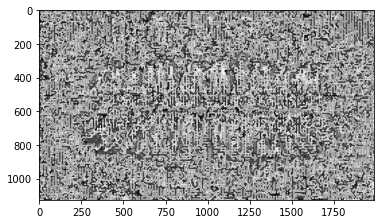

In [ ]:
plt.imshow(np.squeeze(merged), cmap='gray')